# Demo

In [1]:
# Math
import numpy as np
import scipy
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# Graph
import networkx as nx

# Custom - data_gen
from data_gen import gen_graph, sample_lin_scms
# Custom - algo
from bregman_solver import BregmanSolver
# Custom - metrics
from metrics import compare_graphs

# Importing no tears
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from notears.notears.linear import notears_linear

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


## Synthetic graph generation 

##### Constants

In [57]:
graph_type = "scale-free" # choose between "scale-free" and "erdos-renyi"
n = 50
noise_type = "exp" # or "gumbel" or "exp"

In [58]:
G, adj_matrix = gen_graph(graph_type, n, mean_deg=4)

In [59]:
G.number_of_edges()

97

In [60]:
np.sum(adj_matrix)

97.0

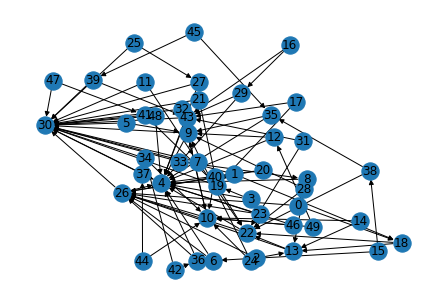

In [61]:
nx.draw(G, with_labels=True)

### Synthetic data generation

In [94]:
X, beta, sigma_n = sample_lin_scms(graph_type, noise_type, adj_matrix, nb_samples=1000, 
                                   weighted=True)#, w_ranges=((-20, -5), (5, 20)))

In [95]:
np.sum(np.abs(beta))

118.60227096008687

In [96]:
n/(n-2)/0.1*n

520.8333333333333

In [97]:
np.sum(np.abs(beta)) > n/(n-2)/0.1*n

False

## Learning

In [98]:
import importlib
import bregman_solver
importlib.reload(bregman_solver)
from bregman_solver import BregmanSolver

In [ ]:
alg = BregmanSolver(version="gen", dagness_exp=0.1/n, dagness_pen=1e2, l1_pen=1e-2, eps=1e-6, 
                    logging=True, mosek=True, max_iter=1000)
%time Wk = alg.run(X)

mosek can't solve 0
mosek can't solve 0
mosek can't solve 0


In [ ]:
logging = alg.log_dict

In [ ]:
values_likelihood = logging["ll_trace"] # ["l2_error"]
values_l1pen = logging["l1_val"] 
values_dagness = logging["dag_constraint"]
values_obj = values_likelihood + logging["dagness_pen"] * values_dagness + logging["l1_pen"] * values_l1pen
logging["obj"] = values_obj
values_change_support = logging["nb_change_support"]

fig, ax1 = plt.subplots()

color = 'tab:red'
l1 = ax1.plot(values_l1pen, label = "Sparcity = $\|A\|_1$", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax2.plot(values_dagness, label="$(\mathrm{Tr}(e^{\\beta A})-n)^2$", color=color)
l2 = ax2.plot(values_dagness, label="DAGness = $\mathrm{Tr}((I+\\beta A)^n)$", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
l3 = ax3.plot(values_likelihood, color=color, label='NLL = $\mathrm{Tr}(\Sigma (D-A)(D-A)^T)$')#-2\log\det(D-A)$')
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")

ax4 = ax1.twinx()
color = 'tab:grey'
l4 = ax4.plot(values_obj, color=color, label='Objective = $f(x)+g(x)$')
ax4.tick_params(axis='y', labelcolor=color)
ax4.set_yscale("log")

ax5 = ax1.twinx()
color = 'tab:pink'
l5 = ax5.plot(values_change_support, color=color, label='Nb change support')
ax5.tick_params(axis='y', labelcolor=color)
ax5.set_yscale("log")

lines = l1 + l2 + l3 + l4 + l5
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, ncol=2,  bbox_to_anchor=(1, 1.4))
plt.title("{} algo".format(alg.version))

#plt.xlim([10, 30])

In [ ]:
sns.heatmap(beta, center=0); plt.xticks([]);  plt.yticks([]); 

In [ ]:
sns.heatmap(Wk, center=0); plt.xticks([]);  plt.yticks([]); 

In [ ]:
compare_graphs(adj_matrix, np.abs(Wk)>=2)

In [ ]:
%time W_notears = notears_linear(X, 1e-5, "l2")

In [ ]:
compare_graphs(adj_matrix, np.abs(W_notears)>2)

In [ ]:
print(np.sum(np.abs(W_notears)))
print(np.sum(np.abs(Wk)))
print(np.sum(np.abs(beta)))
print()
print(np.linalg.norm(X @ (np.eye(n) - W_notears), "fro"))
print(np.linalg.norm(X @ (np.eye(n) - Wk), "fro"))
print(np.linalg.norm(X @ (np.eye(n) - beta), "fro"))
print()
print(np.trace(np.linalg.matrix_power(np.eye(n) + np.int32(np.abs(W_notears)>0.5), n)))
print(np.trace(np.linalg.matrix_power(np.eye(n) + np.int32(np.abs(Wk)>0.5), n)))

## Extra visualisation 

In [48]:
import seaborn as sns

Text(141.0, 0.5, 'Number of iterations')

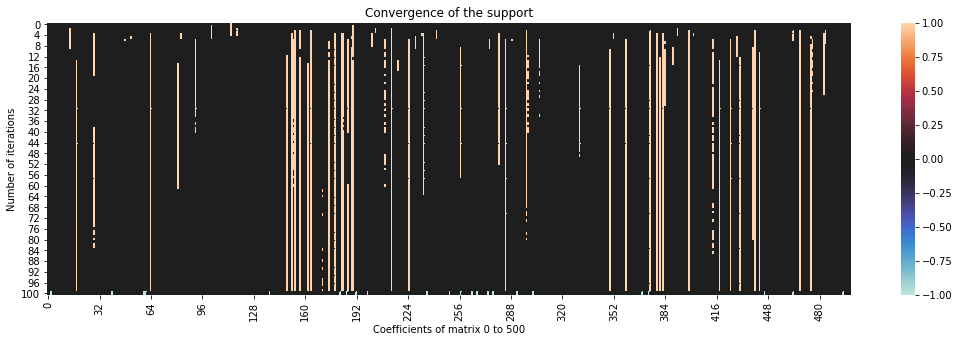

In [49]:
stop = min(100, len(logging["support"]))
plt.figure(figsize=(18,5))
sns.heatmap(np.array(np.append(np.int32(logging["support"][:stop]),#-                                
                               #np.int32(logging["support_neg"][:stop]), 
                               -np.reshape(adj_matrix.flatten(), (1,n*n)), axis=0)),
           center=0); 
#plt.xticks([]); plt.yticks(np.arange(0, stop+1, step=stop//10), np.arange(0, stop+1, step=stop//10));
#plt.ylim(0, 500)
plt.xlim([0, 500])
plt.title("Convergence of the support")
plt.xlabel("Coefficients of matrix 0 to 500")
plt.ylabel("Number of iterations")



